In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

gpytorch.functions.use_toeplitz = False
%matplotlib inline
%load_ext autoreload
%autoreload 2


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from torch.autograd import Variable

n = 201
train_x = torch.zeros(n ** 2, 2)
train_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
train_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
train_y = (train_x[:, 0].abs().lt(0.5)).float() * (train_x[:, 1].abs().lt(0.5)).float() * 2 - 1

train_x = Variable(train_x).cuda()
train_y = Variable(train_y).cuda()

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.models.AdditiveGridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=100, grid_bounds=[(-1, 1)], n_components=2)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

model = GPClassificationModel().cuda()
likelihood = BernoulliLikelihood().cuda()

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = optim.Adam(model.parameters(), lr=0.2)
optimizer.n_iter = 0

def train():
    for i in range(200):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/200 - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()
        
%time train()

Iter 1/200 - Loss: 23.613   log_lengthscale: 0.000
Iter 2/200 - Loss: 28.393   log_lengthscale: -0.200
Iter 3/200 - Loss: 7.911   log_lengthscale: -0.356
Iter 4/200 - Loss: 5.812   log_lengthscale: -0.515
Iter 5/200 - Loss: 13.033   log_lengthscale: -0.682
Iter 6/200 - Loss: 6.218   log_lengthscale: -0.857
Iter 7/200 - Loss: 1.362   log_lengthscale: -1.026
Iter 8/200 - Loss: 1.282   log_lengthscale: -1.196
Iter 9/200 - Loss: 1.229   log_lengthscale: -1.352
Iter 10/200 - Loss: 0.932   log_lengthscale: -1.501
Iter 11/200 - Loss: 0.981   log_lengthscale: -1.639
Iter 12/200 - Loss: 2.073   log_lengthscale: -1.769
Iter 13/200 - Loss: 1.349   log_lengthscale: -1.899
Iter 14/200 - Loss: 2.155   log_lengthscale: -2.031
Iter 15/200 - Loss: 1.386   log_lengthscale: -2.168
Iter 16/200 - Loss: 1.801   log_lengthscale: -2.299
Iter 17/200 - Loss: 2.684   log_lengthscale: -2.425
Iter 18/200 - Loss: 1.488   log_lengthscale: -2.549
Iter 19/200 - Loss: 1.603   log_lengthscale: -2.663
Iter 20/200 - Loss:

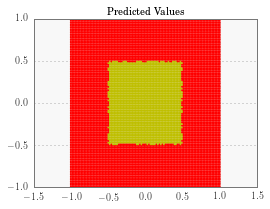

In [6]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
n = 100
test_x = torch.zeros(n ** 2, 2)
test_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
test_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
test_x = Variable(test_x).cuda()
predictions = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.cpu().numpy()
    color = []
    for i in range(len(pred_labels)):
        if pred_labels[i] == 1:
            color.append('y')
        else:
            color.append('r')
    ax.scatter(test_x.data[:, 0].cpu().numpy(), test_x.data[:, 1].cpu().numpy(), color=color, s=1)
    ax.set_ylim([-1, 1])
    ax.set_title(title)

ax_plot(observed_ax, predictions, 'Predicted Values')    